# Exercise 7 - Regression

Fit three `LinearRegressionWithSGD` model and three `RandomForest` model to the three dataset defined below.

## Loading all libraries

In [1]:
# import spark
from pyspark import SparkContext
# initialize a new Spark Context to use for the execution of the script
sc = SparkContext(appName="MY-APP-NAME", master="local[*]")
# prevent useless logging messages
sc.setLogLevel("ERROR")

In [2]:
import math
import numpy as np
import random
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Data Generation

In [4]:
def lin_formula(x):
    return -1.5 + x * 0.5
def sq_formula(x):
    return -1.5 + 0.5 * (x-(interval[1]-interval[0])/2.0) ** 2
def sin_formula(x):
    return -0.5 + np.sin(x/0.75)

In [5]:
number_points = 200
std_dev = 0.15
interval = (0, 5)

np.random.seed(0)
real_x = np.linspace(interval[0], interval[1], (interval[1]-interval[0])*100)
random_x = np.random.uniform(interval[0], interval[1], number_points)

In [6]:
def add_error(x, epsilon=0):
    return x + np.random.normal(0, epsilon, x.shape)

real_lin = lin_formula(real_x)
real_sq = sq_formula(real_x)
real_sin = sin_formula(real_x)

random_lin = add_error(lin_formula(random_x), std_dev)
random_sq = add_error(sq_formula(random_x), std_dev)
random_sin = add_error(sin_formula(random_x), std_dev)

## Visualization input data

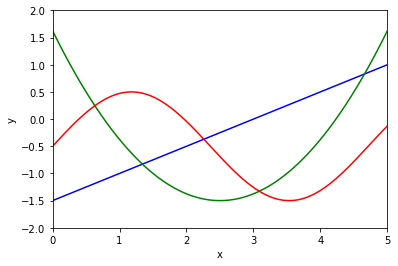

In [7]:
plt.plot(real_x, real_lin, c="b")
plt.plot(real_x, real_sq, c="g")
plt.plot(real_x, real_sin, c="r")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(interval)
plt.ylim((-2,2))
plt.show()

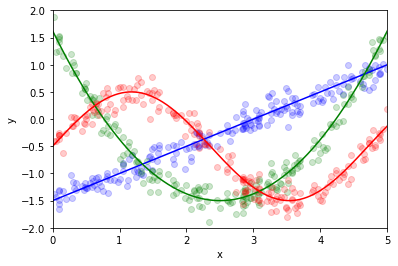

In [8]:
plt.scatter(random_x, random_lin, c="b", alpha=0.2)
plt.scatter(random_x, random_sq, c="g", alpha=0.2)
plt.scatter(random_x, random_sin, c="r", alpha=0.2)
plt.plot(real_x, real_lin, c="b", alpha=1)
plt.plot(real_x, real_sq, c="g", alpha=1)
plt.plot(real_x, real_sin, c="r", alpha=1)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(interval)
plt.ylim((-2,2))
plt.show()

## Training & Predict

In [9]:
rdd_real_x = sc.parallelize(real_x).map(lambda x: np.array([x]))

In [10]:
def transform_to_rdd(x,y):
    return sc.parallelize(np.column_stack((x, y))).map(lambda pair: LabeledPoint(pair[1], np.array([pair[0]])))

train_lin_rdd = transform_to_rdd(random_x, random_lin)
train_sq_rdd = transform_to_rdd(random_x, random_sq)
train_sin_rdd = transform_to_rdd(random_x, random_sin)

### LinearRegressionWithSGD

In [11]:
params = {
    "iterations": 100,
    "step": 1,
    "intercept": True
}
%time lin_model = LinearRegressionWithSGD.train(train_lin_rdd, **params)
%time sq_model = LinearRegressionWithSGD.train(train_sq_rdd, **params)
%time sin_model = LinearRegressionWithSGD.train(train_sin_rdd, **params)

/home/hadoopuser/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


CPU times: user 33.8 ms, sys: 24.8 ms, total: 58.7 ms
Wall time: 4.64 s


/home/hadoopuser/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


CPU times: user 41 ms, sys: 7.77 ms, total: 48.8 ms
Wall time: 1.84 s


/home/hadoopuser/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


CPU times: user 18 ms, sys: 19.5 ms, total: 37.5 ms
Wall time: 1.45 s


Predict using the three models

In [12]:
pred_lin = lin_model.predict(rdd_real_x).collect()
pred_sq = sq_model.predict(rdd_real_x).collect()
pred_sin = sin_model.predict(rdd_real_x).collect()

Plot the predictions against the input points and the original distributions

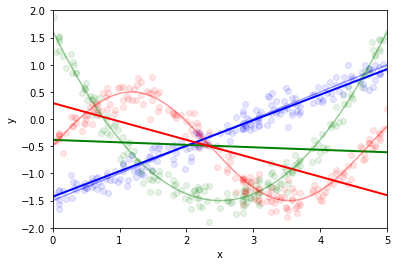

In [13]:
plt.plot(real_x, pred_lin, c="b", linewidth=2)
plt.plot(real_x, pred_sq, c="g", linewidth=2)
plt.plot(real_x, pred_sin, c="r", linewidth=2)
plt.scatter(random_x, random_lin, c="b", alpha=0.1)
plt.scatter(random_x, random_sq, c="g", alpha=0.1)
plt.scatter(random_x, random_sin, c="r", alpha=0.1)
plt.plot(real_x, real_lin, c="b", alpha=0.4)
plt.plot(real_x, real_sq, c="g", alpha=0.4)
plt.plot(real_x, real_sin, c="r", alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(interval)
plt.ylim((-2,2))
plt.show()

# Random Forest

In [14]:
params = {
    "categoricalFeaturesInfo":{},
    "numTrees":50,
    "featureSubsetStrategy":"auto",
    "maxDepth":8,
    "maxBins":64
}
%time lin_model = RandomForest.trainRegressor(train_lin_rdd, **params)
%time sq_model = RandomForest.trainRegressor(train_sq_rdd, **params)
%time sin_model = RandomForest.trainRegressor(train_sin_rdd, **params)

CPU times: user 60.2 ms, sys: 89.7 ms, total: 150 ms
Wall time: 1.76 s
CPU times: user 4.39 ms, sys: 6.94 ms, total: 11.3 ms
Wall time: 1.18 s
CPU times: user 12.2 ms, sys: 15 µs, total: 12.2 ms
Wall time: 899 ms


Predict using the three models

In [15]:
pred_lin = lin_model.predict(rdd_real_x).collect()
pred_sq = sq_model.predict(rdd_real_x).collect()
pred_sin = sin_model.predict(rdd_real_x).collect()

Plot the predictions against the input points and the original distributions

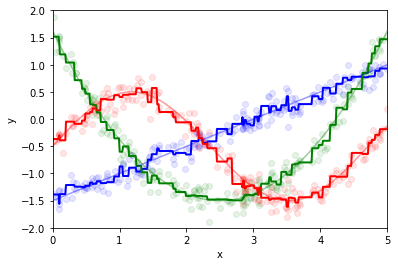

In [16]:
plt.plot(real_x, pred_lin, c="b", linewidth=2)
plt.plot(real_x, pred_sq, c="g", linewidth=2)
plt.plot(real_x, pred_sin, c="r", linewidth=2)
plt.scatter(random_x, random_lin, c="b", alpha=0.1)
plt.scatter(random_x, random_sq, c="g", alpha=0.1)
plt.scatter(random_x, random_sin, c="r", alpha=0.1)
plt.plot(real_x, real_lin, c="b", alpha=0.4)
plt.plot(real_x, real_sq, c="g", alpha=0.4)
plt.plot(real_x, real_sin, c="r", alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(interval)
plt.ylim((-2,2))
plt.show()